# In this notebook I will explore techniques to evaluate and improve machine learning models

In [125]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_blobs

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.keras.backend.set_floatx('float64')
tf.autograph.set_verbosity(0)

In [2]:
dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; dldarkblue =  '#0D5BDC'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]

In [3]:
def gen_data(m, seed=1, scale=0.7):
    """ Generate a data set based on a x^2 with added noise """

    c = 0
    x_train = np.linspace(0,49,m)
    np.random.seed(seed)
    y_ideal = x_train**2 + c
    y_train = y_ideal + scale * y_ideal * (np.random.sample((m,))-0.5)
    x_ideal = x_train # for redraw when new data included in X
    return  x_train, y_train, x_ideal, y_ideal

# Split the data

In [4]:
# Generate the data
X, y, x_ideal, y_ideal = gen_data(18, 2, 0.7)
print("X.shape:", X.shape, "y.shape: ", y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print("X_train.shape:", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape:", X_test.shape, "y_test.shape", y_test.shape)

X.shape: (18,) y.shape:  (18,)
X_train.shape: (12,) y_train.shape (12,)
X_test.shape: (6,) y_test.shape (6,)


# Plot Train, Test Sets

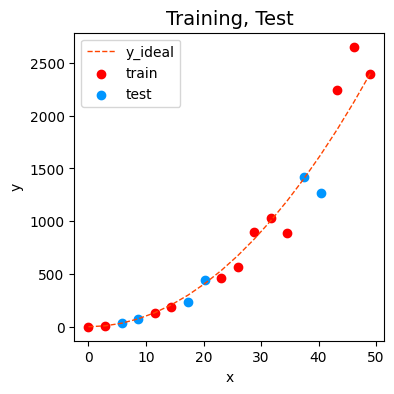

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color='orangered', label="y_ideal", lw=1)
ax.set_title("Training, Test", fontsize=14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color="r", label="train")
ax.scatter(X_test, y_test, color=dlc["dlblue"], label="test")
ax.legend(loc='upper left')
plt.show()

# Error Calculation for model evaluation, linear regression

$$\textbf{J}_{test} (\textbf{w},b) = \frac{1}{2m_{test}} \sum_{i=0}^{m_{test}-1} (f_{\textbf{w},b}(\textbf{x}_{test}^{(i)}) - y_{test}^{(i)})^2$$

I will implement a function to calculate it.

In [6]:
def my_mse(y, yhat):
    """ 
        Calculate the mean square error on a data set.

        Args:
            y           :  (ndarray(m,) or (m,1))   Target value of each example
            yhat        :  (ndarray(m,) or (m,1)    Predicted value of each example
    
        Returns:
            err(scalar) : mean square error
    """

    m = len(y)
    err = 0.0

    for i in range(m):
        err += (y[i] - yhat[i])**2
        
    err = err / (2*m)

    return (err)

# Compare performance on training and test data

Let's build a high degree polynomial model to minimize the error.

In [7]:
# Create a model in sklearn
class lin_model:
    def __init__(self, degree, regularization=False, lambda_=0):
        if regularization:
            self.linear_model = Ridge(alpha=lambda_)
        else:
            self.linear_model = LinearRegression()
        self.poly = PolynomialFeatures(degree, include_bias=False)
        self.scaler = StandardScaler()

    def fit(self, X_train, y_train):
        """ Just fits the data. Mapping and scaling are not repeated"""
        X_train_mapped = self.poly.fit_transform(X_train.reshape(-1,1))
        X_train_mapped_scaled = self.scaler.fit_transform(X_train_mapped)
        self.linear_model.fit(X_train_mapped_scaled, y_train)

    def predict(self, X):
        X_mapped = self.poly.transform(X.reshape(-1,1))
        X_mapped_scaled = self.scaler.transform(X_mapped)
        yhat = self.linear_model.predict(X_mapped_scaled)
        return yhat
    
    def mse(self, y, yhat):
        err = mean_squared_error(y, yhat) / 2
        return (err)

In [8]:
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# Predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# Predict on test data, find test error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

In [9]:
print(f"Training error: {err_train:.2f}, Test error: {err_test:.2f}")

Training error: 58.01, Test error: 171215.01


I can observe that the test error is too high. Let's explore why this is in a plot.

In [10]:
def plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax.plot(x_ideal, y_ideal, "--", color='orangered', label="y_ideal", lw=1)
    ax.set_title("Poor Performance on Test Data", fontsize=12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")


    ax.scatter(X_train, y_train, color=dlc["dldarkred"], label="Train")
    ax.scatter(X_test, y_test, color=dlc["dldarkblue"], label="Test")
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    ax.plot(x, y_pred, lw=0.5, color=dlc["dlblue"], label=f"Predicted, degree={degree}")
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

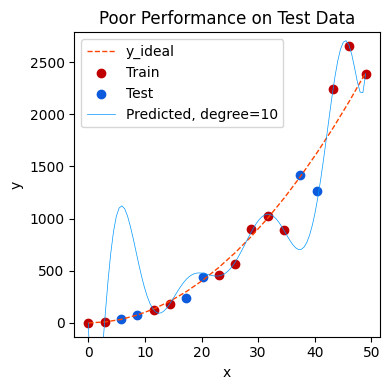

In [11]:
x = np.linspace(0, int(X.max()), 100) # Predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, 10)

As we saw previously, the test error is too high. That means the model will perform bad on new data. According to the split, I used 66.67% for train and 33.33% for test. However, these quantities can vary depending on the size of the data set. Let's explore another alternatives.

In [12]:
# Generate data
X, y, x_ideal, y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape,"Y.shape", y.shape)

# Split the data using sklearn routine
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.50, random_state=1)

del X_, y_

print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) Y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


# Bias and Invariance

Moreover, the degree of the polynomial model was too high. I should change it, but how can I choose a good value? I will try a range of degree values and calculate the performance using the training and cross validation set.

# Train, Cross Validation and Test Visualization

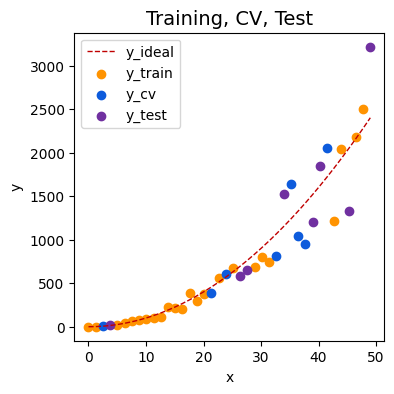

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color=dlc["dldarkred"], label="y_ideal", lw=1)
ax.scatter(X_train, y_train, color=dlc["dlorange"], label="y_train")
ax.scatter(X_cv, y_cv, color=dlc["dldarkblue"], label="y_cv")
ax.scatter(X_test, y_test, color=dlc["dlpurple"], label="y_test")

ax.set_title("Training, CV, Test", fontsize=14)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(loc='upper left')
plt.show()



# Finding the optimal degree

I will use the `scikit-learn` linear regression moderl for speed and simplicity.

In [20]:
max_degree = 9
err_train = np.zeros(max_degree)
err_cv = np.zeros(max_degree)
x = np.linspace(0, int(X.max()), 100)
y_pred = np.zeros((100, max_degree)) # columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)

optimal_degree = np.argmin(err_cv)+1

In [21]:
print(optimal_degree)

2


# Plot the result

In [84]:
def plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, err_train, err_cv, optimal_degree, max_degree):
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
    ax[0].scatter(X_train, y_train, color = "black", marker='v',          label="train")
    ax[0].scatter(X_cv, y_cv,       color = "teal", marker='d', label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,max_degree):
        ax[0].plot(x, y_pred[:,i],  lw=0.6, label=f"{i+1}")
    ax[0].legend(loc='upper left')

    ax[1].set_title("error vs degree",fontsize = 12)
    cpts = list(range(1, max_degree+1))
    ax[1].plot(cpts, err_train[0:], marker='o',label="train error", lw=2,  color = dlc["dlblue"])
    ax[1].plot(cpts, err_cv[0:],    marker='o',label="cv error",  lw=2, color = dlc["dlorange"])
    ax[1].set_ylim(*ax[1].get_ylim())
    ax[1].axvline(optimal_degree, lw=1, color = dlc["dlmagenta"])
    ax[1].annotate("optimal degree", xy=(optimal_degree,80000),xycoords='data',
                xytext=(0.3, 0.8), textcoords='axes fraction', fontsize=10,
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3", 
                                   color=dlc['dldarkred'], lw=1))
    ax[1].set_xlabel("degree")
    ax[1].set_ylabel("error")
    ax[1].legend()
    fig.suptitle("Find Optimal Degree",fontsize = 12)
    plt.tight_layout()

    plt.show()

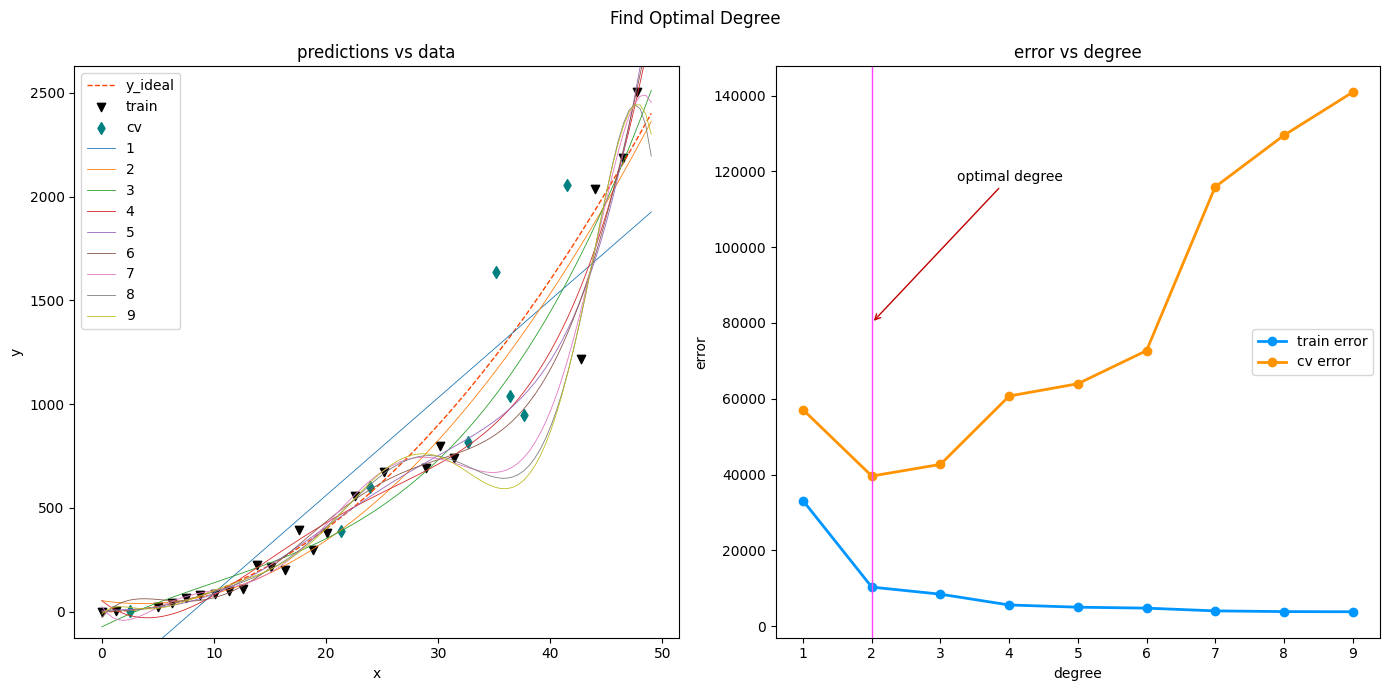

In [85]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, err_train, err_cv, optimal_degree, max_degree)

I can notice in the left plot that the higher the degree is, the better fits to the train data. However, in the right plot, I realize that the train error starts to decrease while the degree increase. Conversely, the cross validation error starts to decrease for a 2-degree model, but it increases for higher degrees leading to over-fit on the training data.

# Tuning Regularization

In the step, I will to tune the regularization parameter lambda $\lambda$ .

In [87]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)
err_cv = np.zeros(num_steps)
x = np.linspace(0, int(X.max()), 100)
y_pred = np.zeros((100, num_steps))     # columns are lines to plot

for i in range(num_steps):
    lambda_ = lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_= lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)

optimal_reg_idx = np.argmin(err_cv)

In [88]:
print(optimal_reg_idx)

7


In [89]:
def plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           label="train")
    ax[0].scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
#   ax[0].plot(x, y_pred[:,:],  lw=0.5, label=[f"$\lambda =${i}" for i in lambda_range])
    for i in (0,3,7,9):
        ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"$\lambda =${lambda_range[i]}")
    ax[0].legend()

    ax[1].set_title("error vs regularization",fontsize = 12)
    ax[1].plot(lambda_range, err_train[:], label="train error", color = dlc["dlblue"])
    ax[1].plot(lambda_range, err_cv[:],    label="cv error",    color = dlc["dlorange"])
    ax[1].set_xscale('log')
    ax[1].set_ylim(*ax[1].get_ylim())
    opt_x = lambda_range[optimal_reg_idx]
    ax[1].vlines(opt_x, *ax[1].get_ylim(), color = "black", lw=1)
    ax[1].annotate("optimal lambda", (opt_x,150000), xytext=(-80,10), textcoords="offset points",
                  arrowprops={'arrowstyle':'simple'})
    ax[1].set_xlabel("regularization (lambda)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning Regularization",fontsize = 12)
    ax[1].text(0.05,0.44,"High\nVariance",fontsize=12, ha='left',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].text(0.95,0.44,"High\nBias",    fontsize=12, ha='right',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

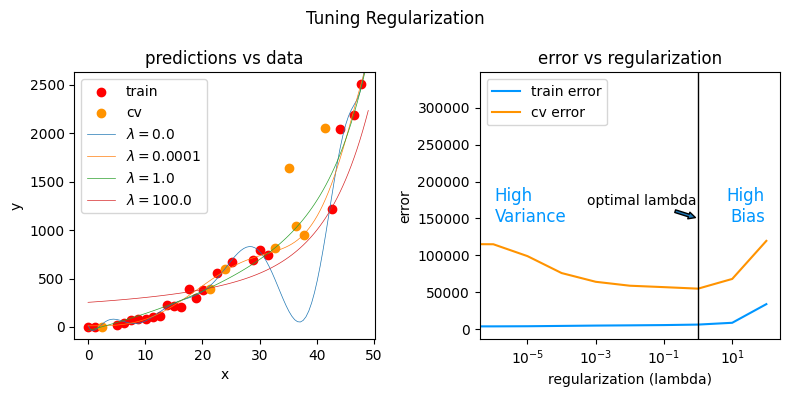

In [90]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

# Getting more data

When a model is overfitting (High Variance), collecting more data can improve performance

In [91]:
def tune_m():
    """ tune the number of examples to reduce overfitting """
    m = 50
    m_range = np.array(m*np.arange(1,16))
    num_steps = m_range.shape[0]
    degree = 16
    err_train = np.zeros(num_steps)     
    err_cv = np.zeros(num_steps)        
    y_pred = np.zeros((100,num_steps))     
    
    for i in range(num_steps):
        X, y, y_ideal, x_ideal = gen_data(m_range[i],5,0.7)
        x = np.linspace(0,int(X.max()),100)  
        X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
        X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)

        lmodel = lin_model(degree)  # no regularization
        lmodel.fit(X_train, y_train)
        yhat = lmodel.predict(X_train)
        err_train[i] = lmodel.mse(y_train, yhat)
        yhat = lmodel.predict(X_cv)
        err_cv[i] = lmodel.mse(y_cv, yhat)
        y_pred[:,i] = lmodel.predict(x)
    return(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree)

In [112]:
def plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree):
    
    fig, ax = plt.subplots(1,2,figsize=(16,8))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "black", marker='x',           s=8, label="train", alpha=0.4)
    ax[0].scatter(X_cv, y_cv,       color = "teal", marker='d', s=8, label="cv",    alpha=0.4)
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,len(m_range),3):
        ax[0].plot(x, y_pred[:,i],  lw=1, label=f"$m =${m_range[i]}")
    ax[0].legend(loc='upper left')
    ax[0].text(0.05,0.5,f"degree = {degree}", fontsize=10, ha='left',transform=ax[0].transAxes,color = dlc["dlblue"])

    ax[1].set_title("error vs number of examples",fontsize = 12)
    ax[1].plot(m_range, err_train[:], label="train error", color = dlc["dlblue"])
    ax[1].plot(m_range, err_cv[:],    label="cv error",    color = dlc["dlorange"])
    ax[1].set_xlabel("Number of Examples (m)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning number of examples",fontsize = 12)
    ax[1].text(0.05,0.5,"High\nVariance",        fontsize=12, ha='left',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].text(0.95,0.5,"Good \nGeneralization", fontsize=12, ha='right',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].legend()
    plt.tight_layout()
    plt.show()

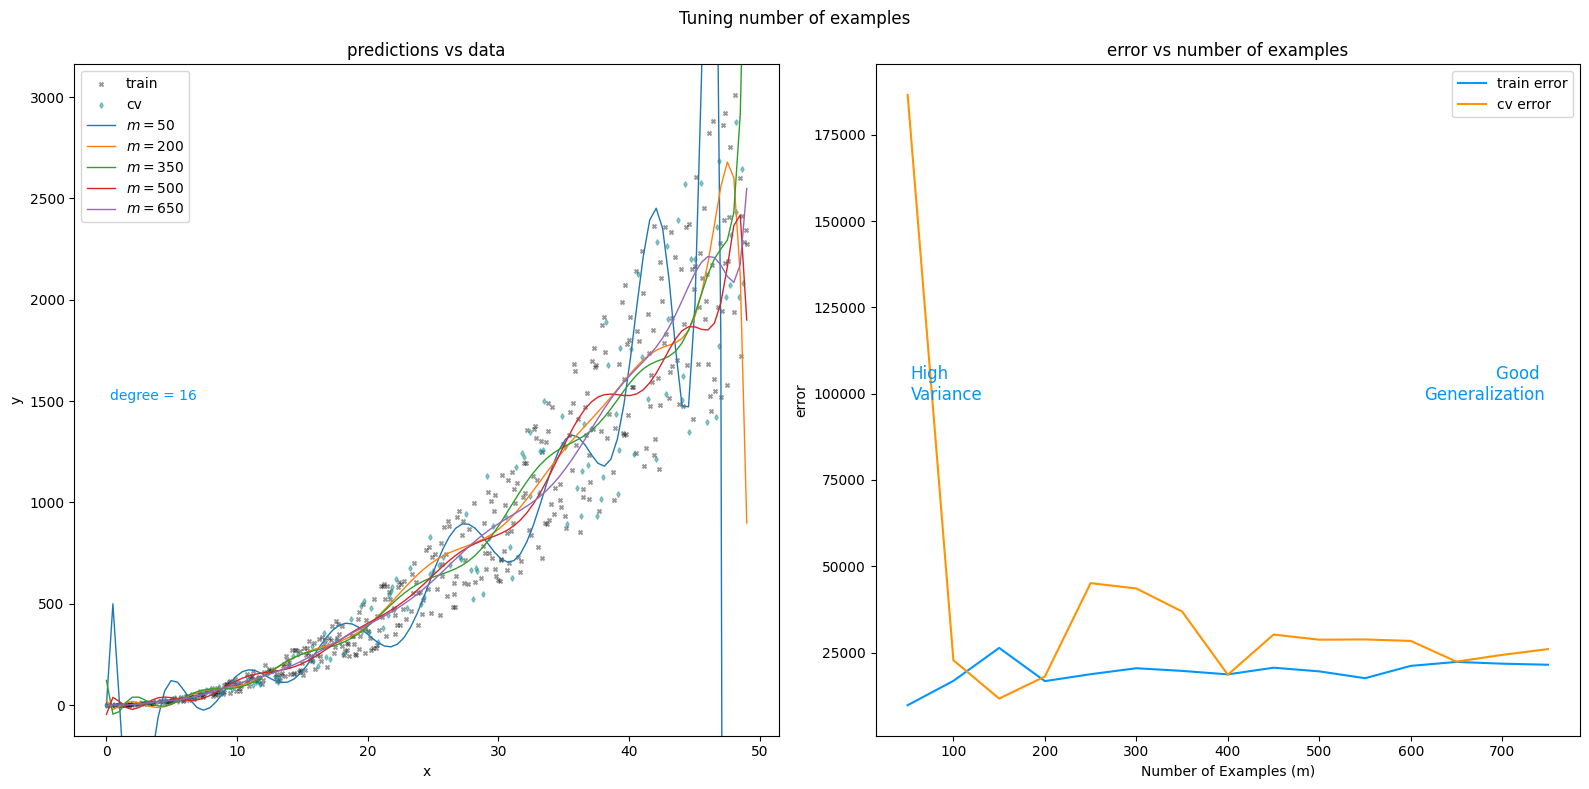

In [113]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values.

# Evaluating a Learning Algorithm (Neural Network)

In [126]:
# cm.Paired has 12 colors, alternating light and dark.
#https://matplotlib.org/stable/tutorials/colors/colormaps.html
dkcolors = plt.cm.Paired((1,3,7,9,5,11))  # pick paired colors
ltcolors = plt.cm.Paired((0,2,6,8,4,10))
dkcolors_map = mpl.colors.ListedColormap(dkcolors) # turn colors into a color map
ltcolors_map = mpl.colors.ListedColormap(ltcolors) # These have 6 entries - see lt_colors_map.colors

In [127]:
# Generate the data

def gen_blobs():
    classes = 6
    m = 800
    std = 0.4
    centers = np.array([[-1, 0], [1, 0], [0, 1], [0, -1],  [-2,1],[-2,-1]])
    X, y = make_blobs(n_samples=m, centers=centers, cluster_std=std, random_state=2, n_features=2)
    return (X, y, centers, classes, std)

In [128]:
def plt_mc_data(ax, X, y, classes,  class_labels=None, map=plt.cm.Paired, legend=False, size=50, m='o'):
    normy = mpl.colors.Normalize(vmin=0, vmax=classes)
    for i in range(classes):
        idx = np.where(y == i)
        label = class_labels[i] if class_labels else "c{}".format(i)
        ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
                   color=map(normy(i)),
                   s=size, label=label)
    if legend: ax.legend(loc='lower right')
    ax.axis('equal')

In [129]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


In [132]:
#Plot a multi-class categorical decision boundary
# This version handles a non-vector prediction (adds a for-loop over points)
def plot_cat_decision_boundary(ax, X,predict , class_labels=None, legend=False, vector=True, color='g', lw = 1):

    # create a mesh to points to plot
    pad = 0.5
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    h = max(x_max-x_min, y_max-y_min)/200
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    #print("points", points.shape)
    #make predictions for each point in mesh
    if vector:
        Z = predict(points)
    else:
        Z = np.zeros((len(points),))
        for i in range(len(points)):
            Z[i] = predict(points[i].reshape(1,2))
    Z = Z.reshape(xx.shape)

    #contour plot highlights boundaries between values - classes in this case
    ax.contour(xx, yy, Z, colors=color, linewidths=lw) 
    ax.axis('tight')

In [135]:
def recat(pt, origins):
    """ categorize a point based on distance from origin of clusters """
    nclusters = len(origins)
    min_dist = 10000
    y_new = None
    for j in range(nclusters):
        temp = origins[j] - pt.reshape(2,)
        #print(temp.shape,origins[j].shape)
        dist = np.sqrt(np.dot(temp.T, temp))
        if dist < min_dist:
            y_new = j
            min_dist = dist
    return(y_new)

In [136]:
def plt_train_eq_dist(X_train,y_train,classes, X_cv,   y_cv, centers, std):
    css = np.unique(y_train)
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plt_mc_data(ax[0], X_train,y_train,classes, map=dkcolors_map, legend=True, size=50)
    plt_mc_data(ax[0], X_cv,   y_cv,   classes, map=ltcolors_map, legend=True, m="<")
    ax[0].set_title("Training, CV Data")
    for c in css:
        circ = plt.Circle(centers[c], 2*std, color=dkcolors_map(c), clip_on=False, fill=False, lw=0.5)
        ax[0].add_patch(circ)


    #make a model for plotting routines to call
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_decision_boundary(ax[1], X_train, cat_predict,  vector=False, color = dlc["dlmagenta"], lw=0.75)
    ax[1].set_title("ideal performance", fontsize=14)

    #add the original data to the decison boundary
    plt_mc_data(ax[1], X_train,y_train, classes, map=dkcolors_map, legend=True, size=50)
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    plt.show()

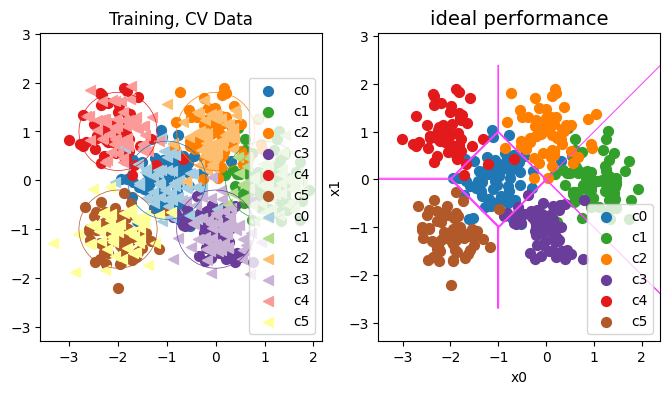

In [137]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.


### Evaluating categorical model by calculating classification error
The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

In [142]:
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    
        if yhat[i] != y[i]:
            incorrect += 1
    
    cerr = incorrect / m     
        
    return(cerr)

##  Model Complexity


Below, I will compose a three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)  
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [143]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation='relu'),
        Dense(40, activation='relu'),
        Dense(6, activation='linear'),
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

2025-04-22 16:56:37.864769: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-22 16:56:37.865095: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [144]:
model.fit(
    X_train, y_train,
    epochs=1000
)

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3546  
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 0.4346
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 0.3321
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 0.2657
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.2177
Epoch 6/1000
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1636

2025-04-22 16:56:47.888027: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:56:47.888110: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:56:47.888135: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:56:47.888179: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:56:47.888200: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:56:47.905435: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:56:47.905510: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:56:47.905537: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:56:47.905584: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:56:47.905609: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.2189
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.2128
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.2084
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 0.2017
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.1967
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.1949
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.1949
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 0.1928
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.1907
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 0.1885
Epoch 16/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 0.1884
Epoch 17/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.1860
Epoch 18/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 0.1833
Epoch 19/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.1842
Epoch 20/1000
13/13 ━━━━━━━━━━━━━━━━━

In [145]:
model.summary()

Model: "Complex"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

In [146]:
def plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle=""):
    #plot the decison boundary.
    fig,ax = plt.subplots(1,2, figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plot_cat_decision_boundary(ax[0], X_train, model_predict,  vector=True)
    ax[0].set_title("training data", fontsize=14)

    #add the original data to the decison boundary
    plt_mc_data(ax[0], X_train,y_train, classes, map=dkcolors_map, legend=True, size=75)
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");

    plot_cat_decision_boundary(ax[1], X_train, model_predict,  vector=True)
    ax[1].set_title("cross-validation data", fontsize=14)
    plt_mc_data(ax[1], X_cv,y_cv, classes, 
                map=ltcolors_map, legend=True, size=100, m='<')
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1"); 
    fig.suptitle(suptitle,fontsize = 12)
    plt.show()

 500/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step

2025-04-22 16:57:56.785424: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:56.785541: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:56.785563: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:56.785662: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:56.785683: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:56.787253: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:56.787340: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:56.787365: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:56.787432: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:56.787455: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


2025-04-22 16:57:57.125474: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:57.125594: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:57.125617: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:57.125719: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:57.125739: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:57.127436: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:57.127527: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:57.127550: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:57.127619: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 16:57:57.127641: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


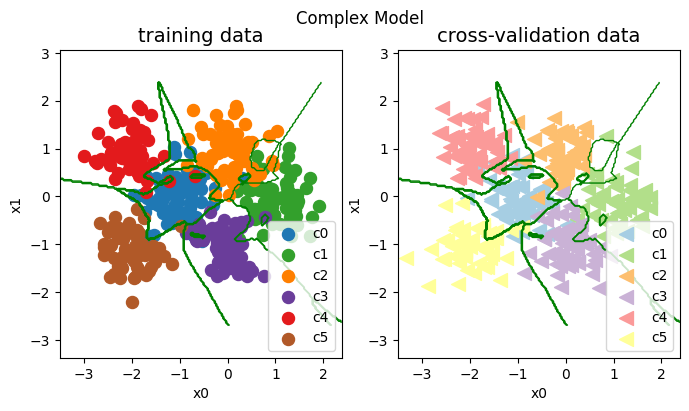

In [147]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [148]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
categorization error, training, complex model: 0.007
categorization error, cv,       complex model: 0.106



### Simple model
Now, let's try a simple model

Below, I will compose a two-layer model:
* Dense layer with 6 units, relu activation
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [149]:
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation='relu'),
        Dense(6, activation='linear'),        
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [150]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

model_s.fit(
    X_train,y_train,
    epochs=1000
)

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 1.7011
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 1.5001
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 1.2939
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 1.0824
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.8933
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 0.7330
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 0.6095
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.5202
Epoch 9/1000


2025-04-22 17:02:11.465230: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:11.465299: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:11.465325: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:11.478562: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:11.478633: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:11.478658: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.4573
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 0.4121
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 0.3789
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 0.3539
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 0.3343
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.3181
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.3046
Epoch 16/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 0.2931
Epoch 17/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 0.2832
Epoch 18/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 0.2745
Epoch 19/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.2667
Epoch 20/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 0.2598
Epoch 21/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 0.2537
Epoch 22/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 0.2481
Epoch 23/1000
13/13 ━━━━━━━━━━━━━━

In [151]:
model_s.summary()

Model: "Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 6)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182 (1.42 KB)

 Trainable params: 60 (480.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 122 (976.00 B)

 618/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step

2025-04-22 17:02:57.533579: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:57.533705: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:57.533727: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:57.534934: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:57.535025: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:57.535054: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
   1/1082 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step

2025-04-22 17:02:57.817873: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:57.817995: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:57.818018: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:57.819285: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:57.819377: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:02:57.819400: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


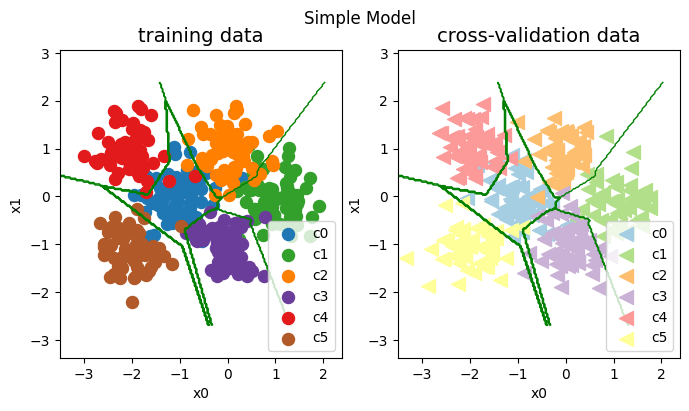

In [152]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

In [153]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
categorization error, training, simple model, 0.068, complex model: 0.007
categorization error, cv,       simple model, 0.072, complex model: 0.106


The simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

## Regularization
As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.

I will reconstruct your complex model, but this time include regularization.
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 40 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [154]:
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(40, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(6, activation='linear'),        
    ], name= None
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [155]:
model_r.fit(
    X_train, y_train,
    epochs=1000
)

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 5.9201
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 1.8130
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 1.4308
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 1.1629
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 1.0436
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.9640
Epoch 7/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 0.9067
Epoch 8/1000


2025-04-22 17:09:00.200526: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:00.200602: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:00.200626: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:00.200670: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:00.200691: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:00.219309: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:00.219383: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:00.219408: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:00.219449: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:00.219471: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 0.8618
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.8325
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.8072
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 0.7903
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 0.7717
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 0.7630
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 0.7587
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.7536
Epoch 16/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 0.7431
Epoch 17/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 0.7222
Epoch 18/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 0.7025
Epoch 19/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 0.6900
Epoch 20/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6721 
Epoch 21/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6611 
Epoch 22/1000
13/13 ━━━━━━━━━━━━━━━━━

In [156]:
model_r.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 120)            │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (127.66 KB)

 Trainable params: 5,446 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,894 (85.11 KB)

 487/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step

2025-04-22 17:09:37.652239: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:37.652365: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:37.652389: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:37.652493: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:37.652515: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:37.654252: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:37.654369: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:37.654392: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:37.654488: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:37.654509: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
   1/1082 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step

2025-04-22 17:09:38.040777: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:38.040903: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:38.040927: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:38.041028: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:38.041058: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:38.042709: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:38.042823: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:38.042846: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:38.042942: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:09:38.042963: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


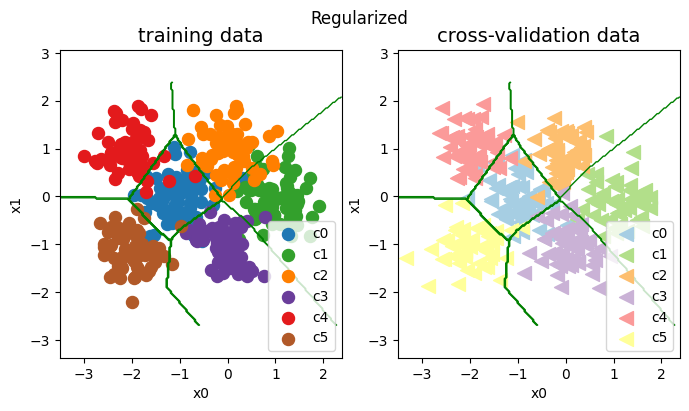

In [157]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

In [158]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
categorization error, training, regularized: 0.068, simple model, 0.068, complex model: 0.007
categorization error, cv,       regularized: 0.069, simple model, 0.072, complex model: 0.106


##  Iterate to find optimal regularization value
As I did in linear regression, I can try many regularization values.

In [159]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)

for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")

Epoch 1/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3312  
Epoch 2/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.4077
Epoch 3/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 0.3514
Epoch 4/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 0.2795
Epoch 5/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 0.2379
Epoch 6/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 0.2220
Epoch 7/1000
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1578

2025-04-22 17:10:40.528441: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:10:40.528541: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:10:40.528579: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:10:40.528634: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:10:40.528658: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:10:40.548860: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:10:40.548959: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:10:40.548997: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:10:40.549057: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:10:40.549157: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.2159
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 0.2085
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 0.2017
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 0.1991
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 0.1981
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 0.1963
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.1935
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 0.1932
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.1914
Epoch 16/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.1897
Epoch 17/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 0.1882
Epoch 18/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 0.1890
Epoch 19/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 0.1856
Epoch 20/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.1861
Epoch 21/1000
13/13 ━━━━━━━━━━━━━━━━

2025-04-22 17:11:04.609222: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:04.609312: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:04.609341: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:04.609408: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:04.609444: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:04.630179: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:04.630264: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:04.630296: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:04.630350: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:04.630374: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 0.2993
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.2809
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 0.2652
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.2652
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.2588
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 0.2556
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 0.2574
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.2517
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.2509
Epoch 16/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.2477
Epoch 17/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 0.2475
Epoch 18/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 0.2462
Epoch 19/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 0.2442
Epoch 20/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.2442
Epoch 21/1000
13/13 ━━━━━━━━━━━━━━━━

2025-04-22 17:11:30.051688: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:30.051781: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:30.051811: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:30.051863: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:30.051889: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:30.073273: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:30.073357: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:30.073386: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:30.073433: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:30.073457: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 0.4675
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.4573
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 0.4509
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.4338
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.4150
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 0.4042
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.3933
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.3836
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.3842
Epoch 16/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.3878
Epoch 17/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.3894
Epoch 18/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 0.3899
Epoch 19/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 0.3887
Epoch 20/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 0.3902
Epoch 21/1000
13/13 ━━━━━━━━━━━━━━━━

2025-04-22 17:11:53.768590: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:53.768682: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:53.768711: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:53.768761: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:53.768785: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:53.789822: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:53.789910: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:53.789937: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:53.789988: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:11:53.790013: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 0.6826
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.6691
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 0.6501
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.6295
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.6108
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 0.6065
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 0.5934
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.5764
Epoch 16/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 0.5655
Epoch 17/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 0.5560
Epoch 18/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 0.5501
Epoch 19/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 0.5375
Epoch 20/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 0.5318
Epoch 21/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.5244
Epoch 22/1000
13/13 ━━━━━━━━━━━━━━━

2025-04-22 17:12:17.726014: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:17.726111: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:17.726141: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:17.726194: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:17.726218: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:17.747083: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:17.747166: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:17.747194: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:17.747240: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:17.747264: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 0.8520
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 0.8113
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.7797
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.7550
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.7350
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.7182
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.7033
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 0.6908
Epoch 16/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.6791
Epoch 17/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 0.6666
Epoch 18/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 0.6559
Epoch 19/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 0.6460
Epoch 20/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 0.6371
Epoch 21/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 0.6287
Epoch 22/1000
13/13 ━━━━━━━━━━━━━━━

2025-04-22 17:12:41.443954: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:41.444046: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:41.444076: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:41.444126: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:41.444151: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:41.465758: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:41.465847: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:41.465875: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:41.465920: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:12:41.465946: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1777 
Epoch 8/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 1.1219
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 1.0749
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 1.0399
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 1.0098
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 0.9850
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.9640
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 0.9453
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.9292
Epoch 16/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.9126
Epoch 17/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 0.8974
Epoch 18/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.8834
Epoch 19/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.8693
Epoch 20/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.8570
Epoch 21/1000
13/13 ━━━━━━━━━━━━━━━━━

2025-04-22 17:13:04.061241: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:13:04.061324: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:13:04.061351: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:13:04.061400: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:13:04.061426: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:13:04.081867: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:13:04.081950: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:13:04.081977: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:13:04.082021: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:13:04.082047: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 1.2756
Epoch 9/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 1.2236
Epoch 10/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 1.1815
Epoch 11/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 1.1472
Epoch 12/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 1.1187
Epoch 13/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 1.0938
Epoch 14/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 1.0717
Epoch 15/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 1.0511
Epoch 16/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 1.0326
Epoch 17/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 1.0153
Epoch 18/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 0.9991
Epoch 19/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 0.9840
Epoch 20/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.9704
Epoch 21/1000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 0.9565
Epoch 22/1000
13/13 ━━━━━━━━━━━━━━━

In [160]:
def plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv):
    err_train = np.zeros(len(lambdas))
    err_cv = np.zeros(len(lambdas))
    for i in range(len(models)):
        err_train[i] = eval_cat_err(y_train,np.argmax( models[i](X_train), axis=1))
        err_cv[i] = eval_cat_err(y_cv, np.argmax( models[i](X_cv), axis=1))

    fig, ax = plt.subplots(1,1,figsize=(6,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax.set_title("error vs regularization",fontsize = 12)
    ax.plot(lambdas, err_train, marker='o', label="train error", color = dlc["dlblue"])
    ax.plot(lambdas, err_cv,    marker='o', label="cv error",    color = dlc["dlorange"])
    ax.set_xscale('log')
    ax.set_ylim(*ax.get_ylim())
    ax.set_xlabel("Regularization (lambda)",fontsize = 14)
    ax.set_ylabel("Error",fontsize = 14)
    ax.legend()
    fig.suptitle("Tuning Regularization",fontsize = 14)
    ax.text(0.05,0.14,"Training Error\nlower than CV",fontsize=12, ha='left',transform=ax.transAxes,color = dlc["dlblue"])
    ax.text(0.95,0.14,"Similar\nTraining, CV",    fontsize=12, ha='right',transform=ax.transAxes,color = dlc["dlblue"])
    plt.show()

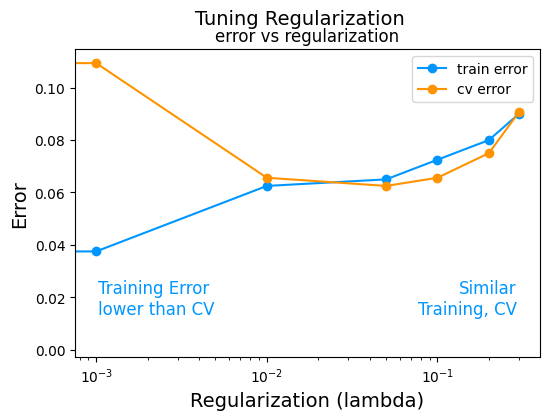

In [161]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

In [162]:
def plt_compare(X,y, classes, simple, regularized, centers):
    plt.close("all")
    fig,ax = plt.subplots(1,3, figsize=(8,3))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

  #plt simple   
    plot_cat_decision_boundary(ax[0], X, simple,  vector=True)
    ax[0].set_title("Simple Model", fontsize=14)
    plt_mc_data(ax[0], X,y, classes, map=dkcolors_map, legend=True, size=75)
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");

  #plt regularized   
    plot_cat_decision_boundary(ax[1], X, regularized,  vector=True)
    ax[1].set_title("Regularized Model", fontsize=14)
    plt_mc_data(ax[1], X,y, classes, map=dkcolors_map, legend=True, size=75)
    ax[1].set_xlabel('x0') ; ax[0].set_ylabel("x1");

  #plt ideal
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_decision_boundary(ax[2], X, cat_predict,  vector=False)
    ax[2].set_title("Ideal Model", fontsize=14)
    plt_mc_data(ax[2], X,y, classes, map=dkcolors_map, legend=True, size=75)
    ax[2].set_xlabel('x0') ; ax[0].set_ylabel("x1");

    err_s = eval_cat_err(y, simple(X))
    err_r = eval_cat_err(y, regularized(X))
    ax[0].text(-2.75,3,f"err_test={err_s:0.2f}", fontsize=11)
    ax[1].text(-2.75,3,f"err_test={err_r:0.2f}", fontsize=11)
    m = len(X)
    y_eq  = np.zeros(m)
    for i in range(m):
        y_eq[i] = recat(X[i], centers)
    err_eq = eval_cat_err(y, y_eq)
    ax[2].text(-2.75,3,f"err_test={err_eq:0.2f}", fontsize=11)
    plt.show()



### Test
Let's try our optimized models on the test set and compare them to 'ideal' performance.

 598/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step

2025-04-22 17:20:20.269760: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:20.269887: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:20.269911: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:20.271173: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:20.271275: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:20.271301: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
 445/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step

2025-04-22 17:20:20.700325: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:20.700444: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:20.700467: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:20.700561: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:20.700582: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:20.702211: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:20.702335: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:20.702361: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:20.702456: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:20.702476: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


2025-04-22 17:20:21.518229: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:21.518368: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:21.518406: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:21.519870: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:21.519962: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:21.519987: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:21.559289: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:21.559404: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:21.559426: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:21.559521: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-04-22 17:20:21.559541: W tensorflow/core/util/util.cc:161] Not handling typ

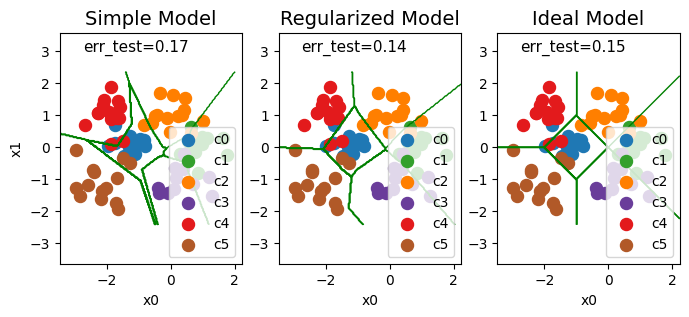

In [163]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.